This code experiments with normalizing flows used to invert Milne-Eddington atmospheres. In this case, a series of penumbra formation maps (Stokes parameters at different wavelengths for each pixel) is considered. This dataset contains maps of a certain FOV at different times to track the evolution of a penumbra in a sunspot. The last map of this dataset is always used as the testing set, while incrementally many maps prior to the last map are used as training data for a normalizing flow learning how to do Milne-Eddington inversions. The goal of this experiment would be to see, if taking into account incrementally many maps for training increases the performance of the inversion on the last map of the time series and furthermore if the "smoothing" effect of the normalizing flow vanishes or not. This fexperiment therefore provides further initial tests for the idea, that inversions can be vastly accelerated by means of using normalizing flows. That is, a map is initially inverted using a (sophisticated) inversion algorithm. After that, a normalizing flow can be trained on this inverted map and then applied to similar FOV's and maps, thereby greatly accelerating the inversion and furthermore providing one with not only parameter values, but distributions!

# Import packages and data

In [1]:
# Import all important packages and set parameters
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#!pip install emcee
#!pip install corner
#!pip install nflows
import emcee
from __future__ import division
from tqdm import tqdm
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.interpolate import CubicSpline
import torch
import torch.nn as nn
import itertools
import numpy as np
import pandas as pd
from math import pi 
import seaborn as sns
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseQuadraticCouplingTransform
from nflows.transforms.permutations import ReversePermutation
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

from sklearn.model_selection import train_test_split

from utils import *

In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

# Import maps

In [3]:
# Import all necessary packages for data generation
import os

# Save current directory
current_directory = os.getcwd()

# Change working path to pyMilne directory and load Milne-Eddington code
os.chdir('/home/dz/pyMilne') # Reference to pyMilne directory
import MilneEddington

In [4]:
# Decide to work in float32
dtype = 'float32'

In [5]:
# Read all available/desired maps into dictionary
frames = [0,1,2,19]  # Load available frames
map_inv_dict, hdulist_dict, regions_dict = read_maps(frames)

In [6]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

# Invert maps using the Milne-Eddington algorithm

In [7]:
# Restore working directory
os.chdir(current_directory)

In [8]:
# Invert maps, if not done yet
# inverted_map_dict, errors_map_dict, syn_spectra_map_dict = invert_store_and_save(frames, map_inv_dict, regions_dict)

In [9]:
# Load inveted maps, if already inverted
inverted_map_dict, errors_map_dict, syn_spectra_map_dict = load_inv_maps(frames)

In [10]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cu121


# Train on first map, test on last map
## Define training and testing datasets, dataloaders and train the flow

In [11]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [12]:
# Instantiate params dictionary
settings = dictionary()

In [13]:
# Reshape training data
spectra_map0 = map_inv_dict[0].reshape(map_inv_dict[0].shape[0]*map_inv_dict[0].shape[1], map_inv_dict[0].shape[2]*map_inv_dict[0].shape[3])
parameters_map0 = inverted_map_dict[0].reshape(inverted_map_dict[0].shape[0]*inverted_map_dict[0].shape[1], inverted_map_dict[0].shape[2])

# Create datasets of training data
spectra = spectra_map0
parameters = parameters_map0

# Create datasets of testing data
spectra_map19 = map_inv_dict[19].reshape(map_inv_dict[19].shape[0]*map_inv_dict[19].shape[1], map_inv_dict[19].shape[2]*map_inv_dict[19].shape[3])
parameters_map19 = inverted_map_dict[19].reshape(inverted_map_dict[19].shape[0]*inverted_map_dict[19].shape[1], inverted_map_dict[19].shape[2])

In [14]:
# Print shape of data
print(f'Shape of true spectra data is: {spectra.shape}')
print(f'Shape of true parameters data is: {parameters.shape}')

Shape of true spectra data is: (330000, 52)
Shape of true parameters data is: (330000, 9)


In [15]:
# Test for NaN values in data
has_nan = np.isnan(spectra).any()
if has_nan==False:
    has_nan = np.isnan(parameters).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [16]:
# Define input x and context y
x = parameters # parameters
y = spectra # spectra

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define scalers for testing map
x_scaler_map19 = StandardScaler().fit(parameters_map19)
y_scaler_map19 = StandardScaler().fit(spectra_map19)
x_std_map19 = x_scaler_test.transform(parameters_map19)
y_std_map19 = y_scaler_test.transform(spectra_map19)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (297000, 9)
Context y_std_train shape: (297000, 52)
Output z_train shape: (297000, 9)
Input x_std_test shape: (33000, 9)
Context y_std_test shape: (33000, 52)
Output z_test shape: (33000, 9)


In [17]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [18]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([297000, 9])
Size of y_std_train: torch.Size([297000, 52])
Size of z_train: torch.Size([297000, 9])
Size of x_std_test: torch.Size([33000, 9])
Size of y_std_test: torch.Size([33000, 52])
Size of z_test: torch.Size([33000, 9])


In [19]:
# Define dataloaders for training and testing
settings.batch_size = 512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [20]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 16 # Try 128
settings.num_layers = 5 # Try 8

In [21]:
# Define functions for flow definitions
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

In [22]:
# Instantiate the normalizing flow
base_dist = StandardNormal(shape=[settings.input_size])
flowtransforms = []
for _ in range(settings.num_layers):
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
    flowtransforms.append(PiecewiseRationalQuadraticCouplingTransform(_, settings.input_size,
                                                                      settings.hidden_size, context_size=settings.context_size))
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
flowtransforms = CompositeTransform(flowtransforms)

flow = Flow(flowtransforms, base_dist)

In [23]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 10

# Define optimizer and scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

In [24]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        flow.train()
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        flow.eval()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/10 train loss: 0.0022
Epoch 1/10 test loss: -0.0049
Epoch 2/10 train loss: -0.0076
Epoch 2/10 test loss: -0.0088
Epoch 3/10 train loss: -0.0096
Epoch 3/10 test loss: -0.0099
Epoch 4/10 train loss: -0.0107
Epoch 4/10 test loss: -0.0108
Epoch 5/10 train loss: -0.0113
Epoch 5/10 test loss: -0.0112
Epoch 6/10 train loss: -0.0116
Epoch 6/10 test loss: -0.0113
Epoch 7/10 train loss: -0.0118
Epoch 7/10 test loss: -0.0115
Epoch 8/10 train loss: -0.0119
Epoch 8/10 test loss: -0.0116
Epoch 9/10 train loss: -0.0119
Epoch 9/10 test loss: -0.0116
Epoch 10/10 train loss: -0.0120
Epoch 10/10 test loss: -0.0116


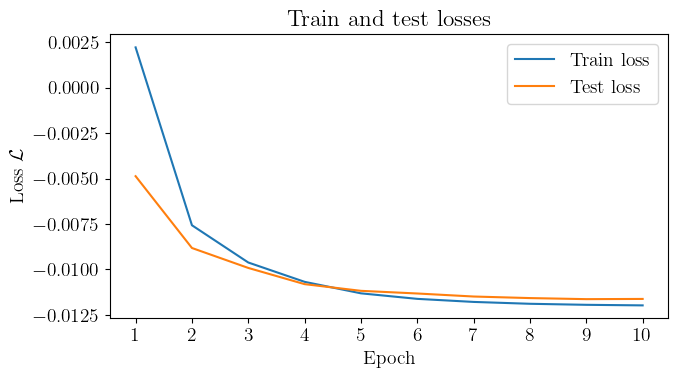

In [25]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-5-loss-1train-nflows-piecewisequadratic.pdf')

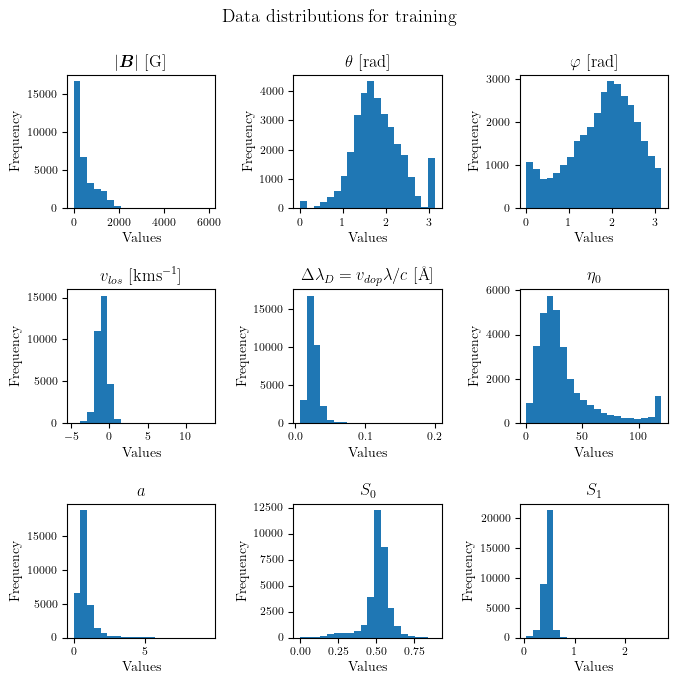

In [26]:
# Plot histogram of training data
plot_histograms(x_test, l_units, 'Data distributions for training', savename='nf-milne-eddington-example-5-datadistributiontraining-1train-nflows-piecewisequadratic.pdf')

## Invert last map using the trained normalizing flow

In [27]:
# Take a sample from the testing map
settings.which_dataindex = 175000
settings.exp_samples = 5000
expval = parameters_map19[settings.which_dataindex,:]
expobs = spectra_map19[settings.which_dataindex,:]
z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_scaler_map19.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x = x_scaler_map19.inverse_transform(rec_x_std[0])

/home/dz/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(


In [28]:
# Plot actual values of features for tested spectrum
for i in range(len(labels)):
    print(f'{labels[i]}: {expval[i]}')

$|\bm{B}|$: 892.6149291992188
$\theta$: 2.664478063583374
$\varphi$: 2.7033779621124268
$v_{los}$: 0.0541003942489624
$\Delta \lambda_D = v_{dop}\lambda/c$: 0.03092404268682003
$\eta_0$: 26.957412719726562
$a$: 0.837792694568634
$S_0$: 0.530448853969574
$S_1$: 0.4645920991897583


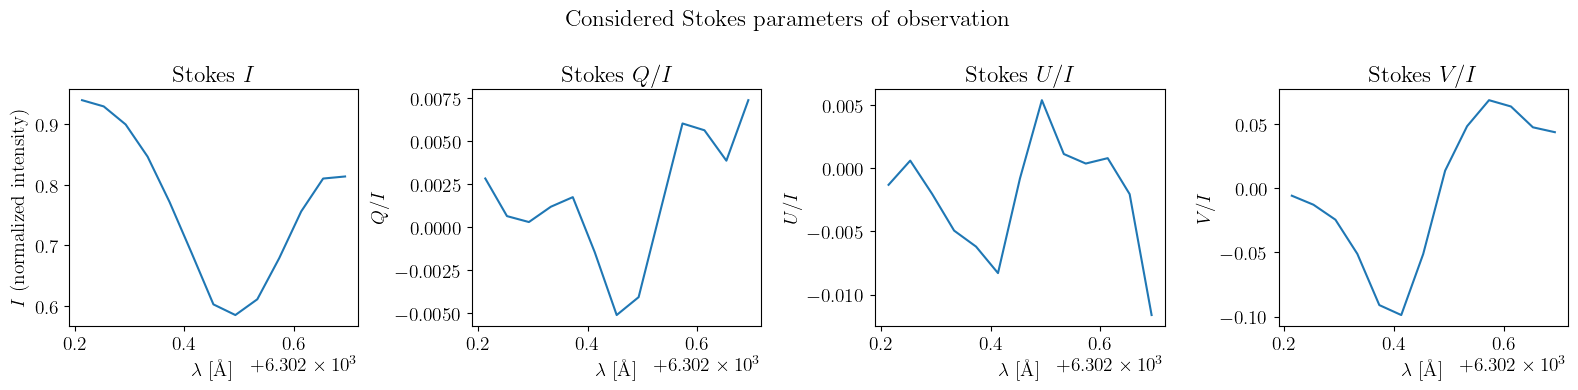

In [29]:
# Plot stokes profiles
plot_stokes_simple(spectra_map19, regions_dict[19][0][0], settings.which_dataindex, stokes_labels, title='Considered Stokes parameters of observation', savename='nf-milne-eddington-example-5-corner-test-spectrum-nflows-piecewisequadratic.pdf')

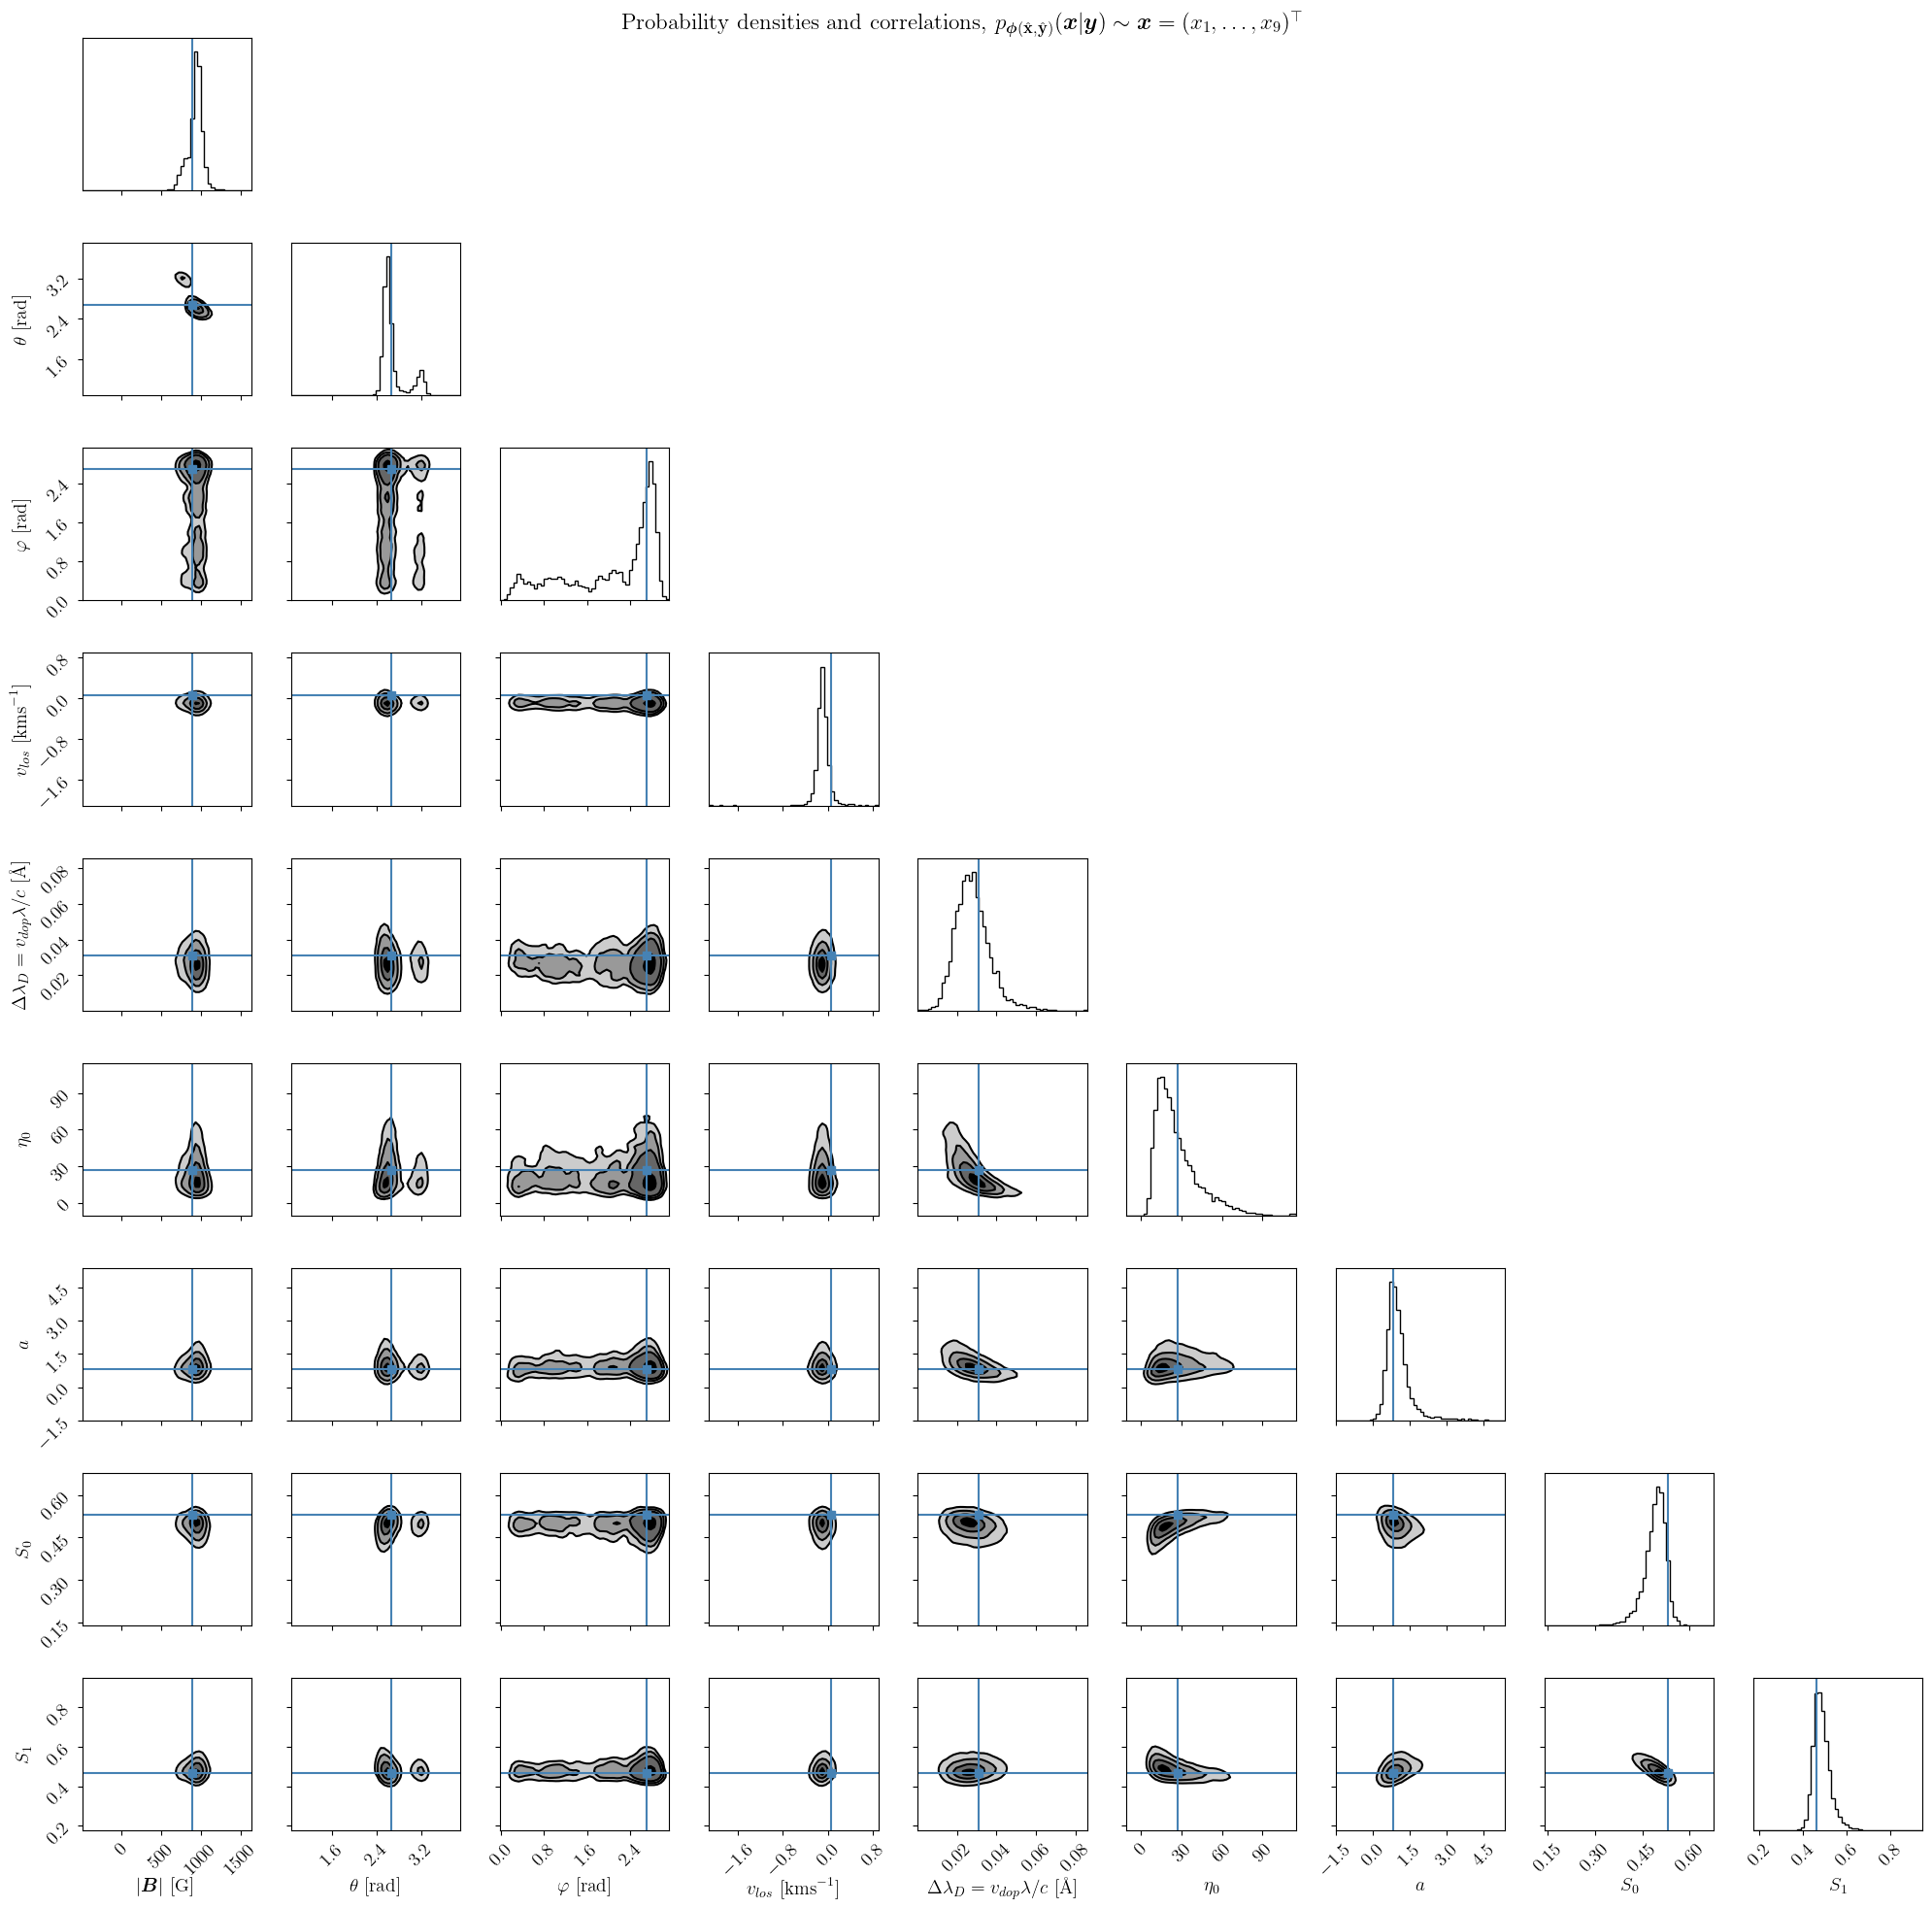

In [30]:
# Produce corner plot
figure = corner.corner(rec_x, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-5-corner-1train-nflows-piecewisequadratic.pdf')

In [31]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

batch_size  :  512
input_size  :  9
context_size  :  52
hidden_size  :  16
num_layers  :  5
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  10
which_dataindex  :  175000
exp_samples  :  5000


In [32]:
# Invert map using the trained normalizing flow
parameters_map19_1train, err_parameters_map19_1train = invert_nflow(spectra_map19, parameters_map19.shape[1], flow, y_scaler_map19, x_scaler_map19)
np.save('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/parameters_map19_1train.npy', parameters_map19_1train)
np.save('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/err_parameters_map19_1train.npy', err_parameters_map19_1train)

100%|█████████████████████████████████████████████████████████████████████████| 330000/330000 [3:20:44<00:00, 27.40it/s]


# Train on first and second map, test on last map
## Define training and testing datasets, dataloaders and train the flow

In [11]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [12]:
# Instantiate params dictionary
settings = dictionary()

In [13]:
# Reshape training data
spectra_map0 = map_inv_dict[0].reshape(map_inv_dict[0].shape[0]*map_inv_dict[0].shape[1], map_inv_dict[0].shape[2]*map_inv_dict[0].shape[3])
spectra_map1 = map_inv_dict[1].reshape(map_inv_dict[1].shape[0]*map_inv_dict[1].shape[1], map_inv_dict[1].shape[2]*map_inv_dict[1].shape[3])
parameters_map0 = inverted_map_dict[0].reshape(inverted_map_dict[0].shape[0]*inverted_map_dict[0].shape[1], inverted_map_dict[0].shape[2])
parameters_map1 = inverted_map_dict[1].reshape(inverted_map_dict[1].shape[0]*inverted_map_dict[1].shape[1], inverted_map_dict[1].shape[2])

# Create datasets of training data
spectra = np.vstack((spectra_map0, spectra_map1))
parameters = np.vstack((parameters_map0, parameters_map1))

# Create datasets of testing data
spectra_map19 = map_inv_dict[19].reshape(map_inv_dict[19].shape[0]*map_inv_dict[19].shape[1], map_inv_dict[19].shape[2]*map_inv_dict[19].shape[3])
parameters_map19 = inverted_map_dict[19].reshape(inverted_map_dict[19].shape[0]*inverted_map_dict[19].shape[1], inverted_map_dict[19].shape[2])

In [14]:
# Print shape of data
print(f'Shape of true spectra data is: {spectra.shape}')
print(f'Shape of true parameters data is: {parameters.shape}')

Shape of true spectra data is: (660000, 52)
Shape of true parameters data is: (660000, 9)


In [15]:
# Test for NaN values in data
has_nan = np.isnan(spectra).any()
if has_nan==False:
    has_nan = np.isnan(parameters).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [16]:
# Define input x and context y
x = parameters # parameters
y = spectra # spectra

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define scalers for testing map
x_scaler_map19 = StandardScaler().fit(parameters_map19)
y_scaler_map19 = StandardScaler().fit(spectra_map19)
x_std_map19 = x_scaler_test.transform(parameters_map19)
y_std_map19 = y_scaler_test.transform(spectra_map19)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (594000, 9)
Context y_std_train shape: (594000, 52)
Output z_train shape: (594000, 9)
Input x_std_test shape: (66000, 9)
Context y_std_test shape: (66000, 52)
Output z_test shape: (66000, 9)


In [17]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [18]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([594000, 9])
Size of y_std_train: torch.Size([594000, 52])
Size of z_train: torch.Size([594000, 9])
Size of x_std_test: torch.Size([66000, 9])
Size of y_std_test: torch.Size([66000, 52])
Size of z_test: torch.Size([66000, 9])


In [19]:
# Define dataloaders for training and testing
settings.batch_size = 2*512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [20]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 16
settings.num_layers = 5

In [21]:
# Define functions for flow definitions
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

In [22]:
# Instantiate the normalizing flow
base_dist = StandardNormal(shape=[settings.input_size])
flowtransforms = []
for _ in range(settings.num_layers):
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
    flowtransforms.append(PiecewiseRationalQuadraticCouplingTransform(_, settings.input_size,
                                                                      settings.hidden_size, context_size=settings.context_size))
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
flowtransforms = CompositeTransform(flowtransforms)

flow = Flow(flowtransforms, base_dist)

In [23]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 10

# Define optimizer and scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

In [24]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        flow.train()
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        flow.eval()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/10 train loss: 0.0002
Epoch 1/10 test loss: -0.0032
Epoch 2/10 train loss: -0.0046
Epoch 2/10 test loss: -0.0047
Epoch 3/10 train loss: -0.0056
Epoch 3/10 test loss: -0.0055
Epoch 4/10 train loss: -0.0061
Epoch 4/10 test loss: -0.0056
Epoch 5/10 train loss: -0.0064
Epoch 5/10 test loss: -0.0056
Epoch 6/10 train loss: -0.0065
Epoch 6/10 test loss: -0.0057
Epoch 7/10 train loss: -0.0066
Epoch 7/10 test loss: -0.0059
Epoch 8/10 train loss: -0.0066
Epoch 8/10 test loss: -0.0059
Epoch 9/10 train loss: -0.0067
Epoch 9/10 test loss: -0.0059
Epoch 10/10 train loss: -0.0067
Epoch 10/10 test loss: -0.0059


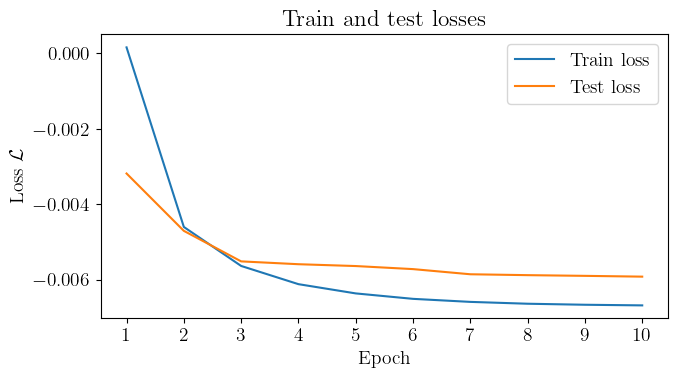

In [25]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-5-loss-2train-nflows-piecewisequadratic.pdf')

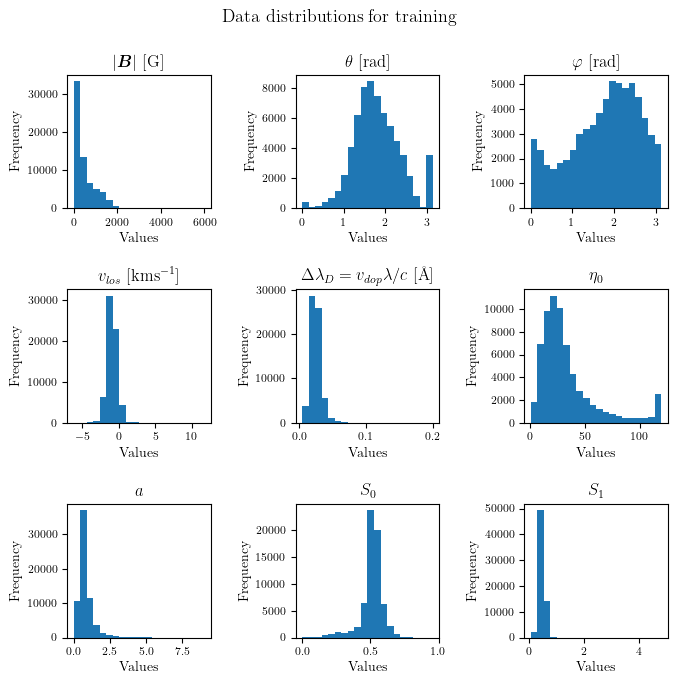

In [26]:
# Plot histogram of training data
plot_histograms(x_test, l_units, 'Data distributions for training', savename='nf-milne-eddington-example-5-datadistributiontraining-2train-nflows-piecewisequadratic.pdf')

## Invert last map using the trained normalizing flow

In [27]:
# Take a sample from the testing map
settings.which_dataindex = 175000
settings.exp_samples = 5000
expval = parameters_map19[settings.which_dataindex,:]
expobs = spectra_map19[settings.which_dataindex,:]
z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_scaler_map19.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x = x_scaler_map19.inverse_transform(rec_x_std[0])

/home/dz/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(


In [28]:
# Plot actual values of features for tested spectrum
for i in range(len(labels)):
    print(f'{labels[i]}: {expval[i]}')

$|\bm{B}|$: 892.6149291992188
$\theta$: 2.664478063583374
$\varphi$: 2.7033779621124268
$v_{los}$: 0.0541003942489624
$\Delta \lambda_D = v_{dop}\lambda/c$: 0.03092404268682003
$\eta_0$: 26.957412719726562
$a$: 0.837792694568634
$S_0$: 0.530448853969574
$S_1$: 0.4645920991897583


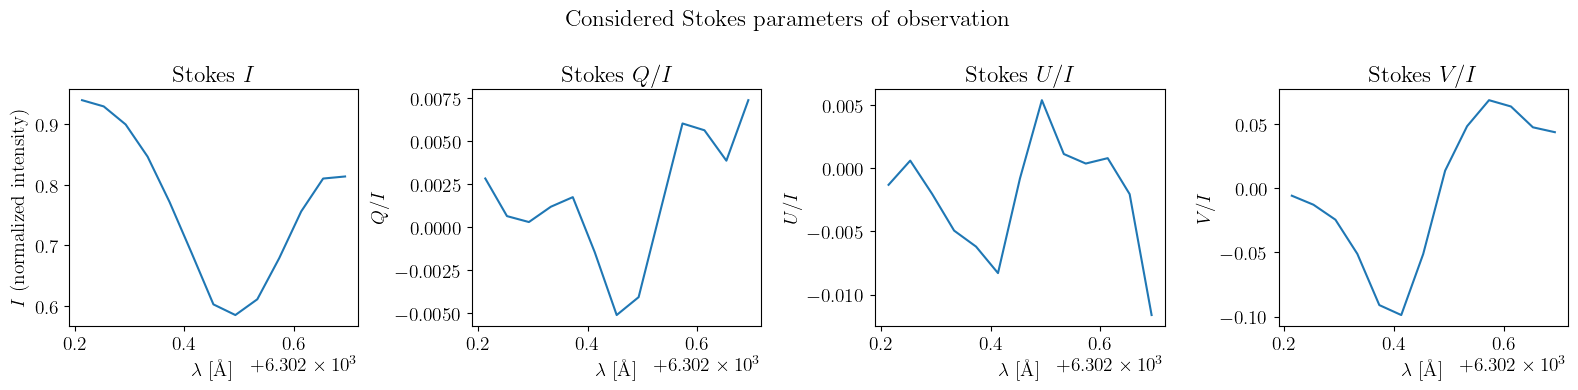

In [29]:
# Plot stokes profiles
plot_stokes_simple(spectra_map19, regions_dict[19][0][0], settings.which_dataindex, stokes_labels, title='Considered Stokes parameters of observation')

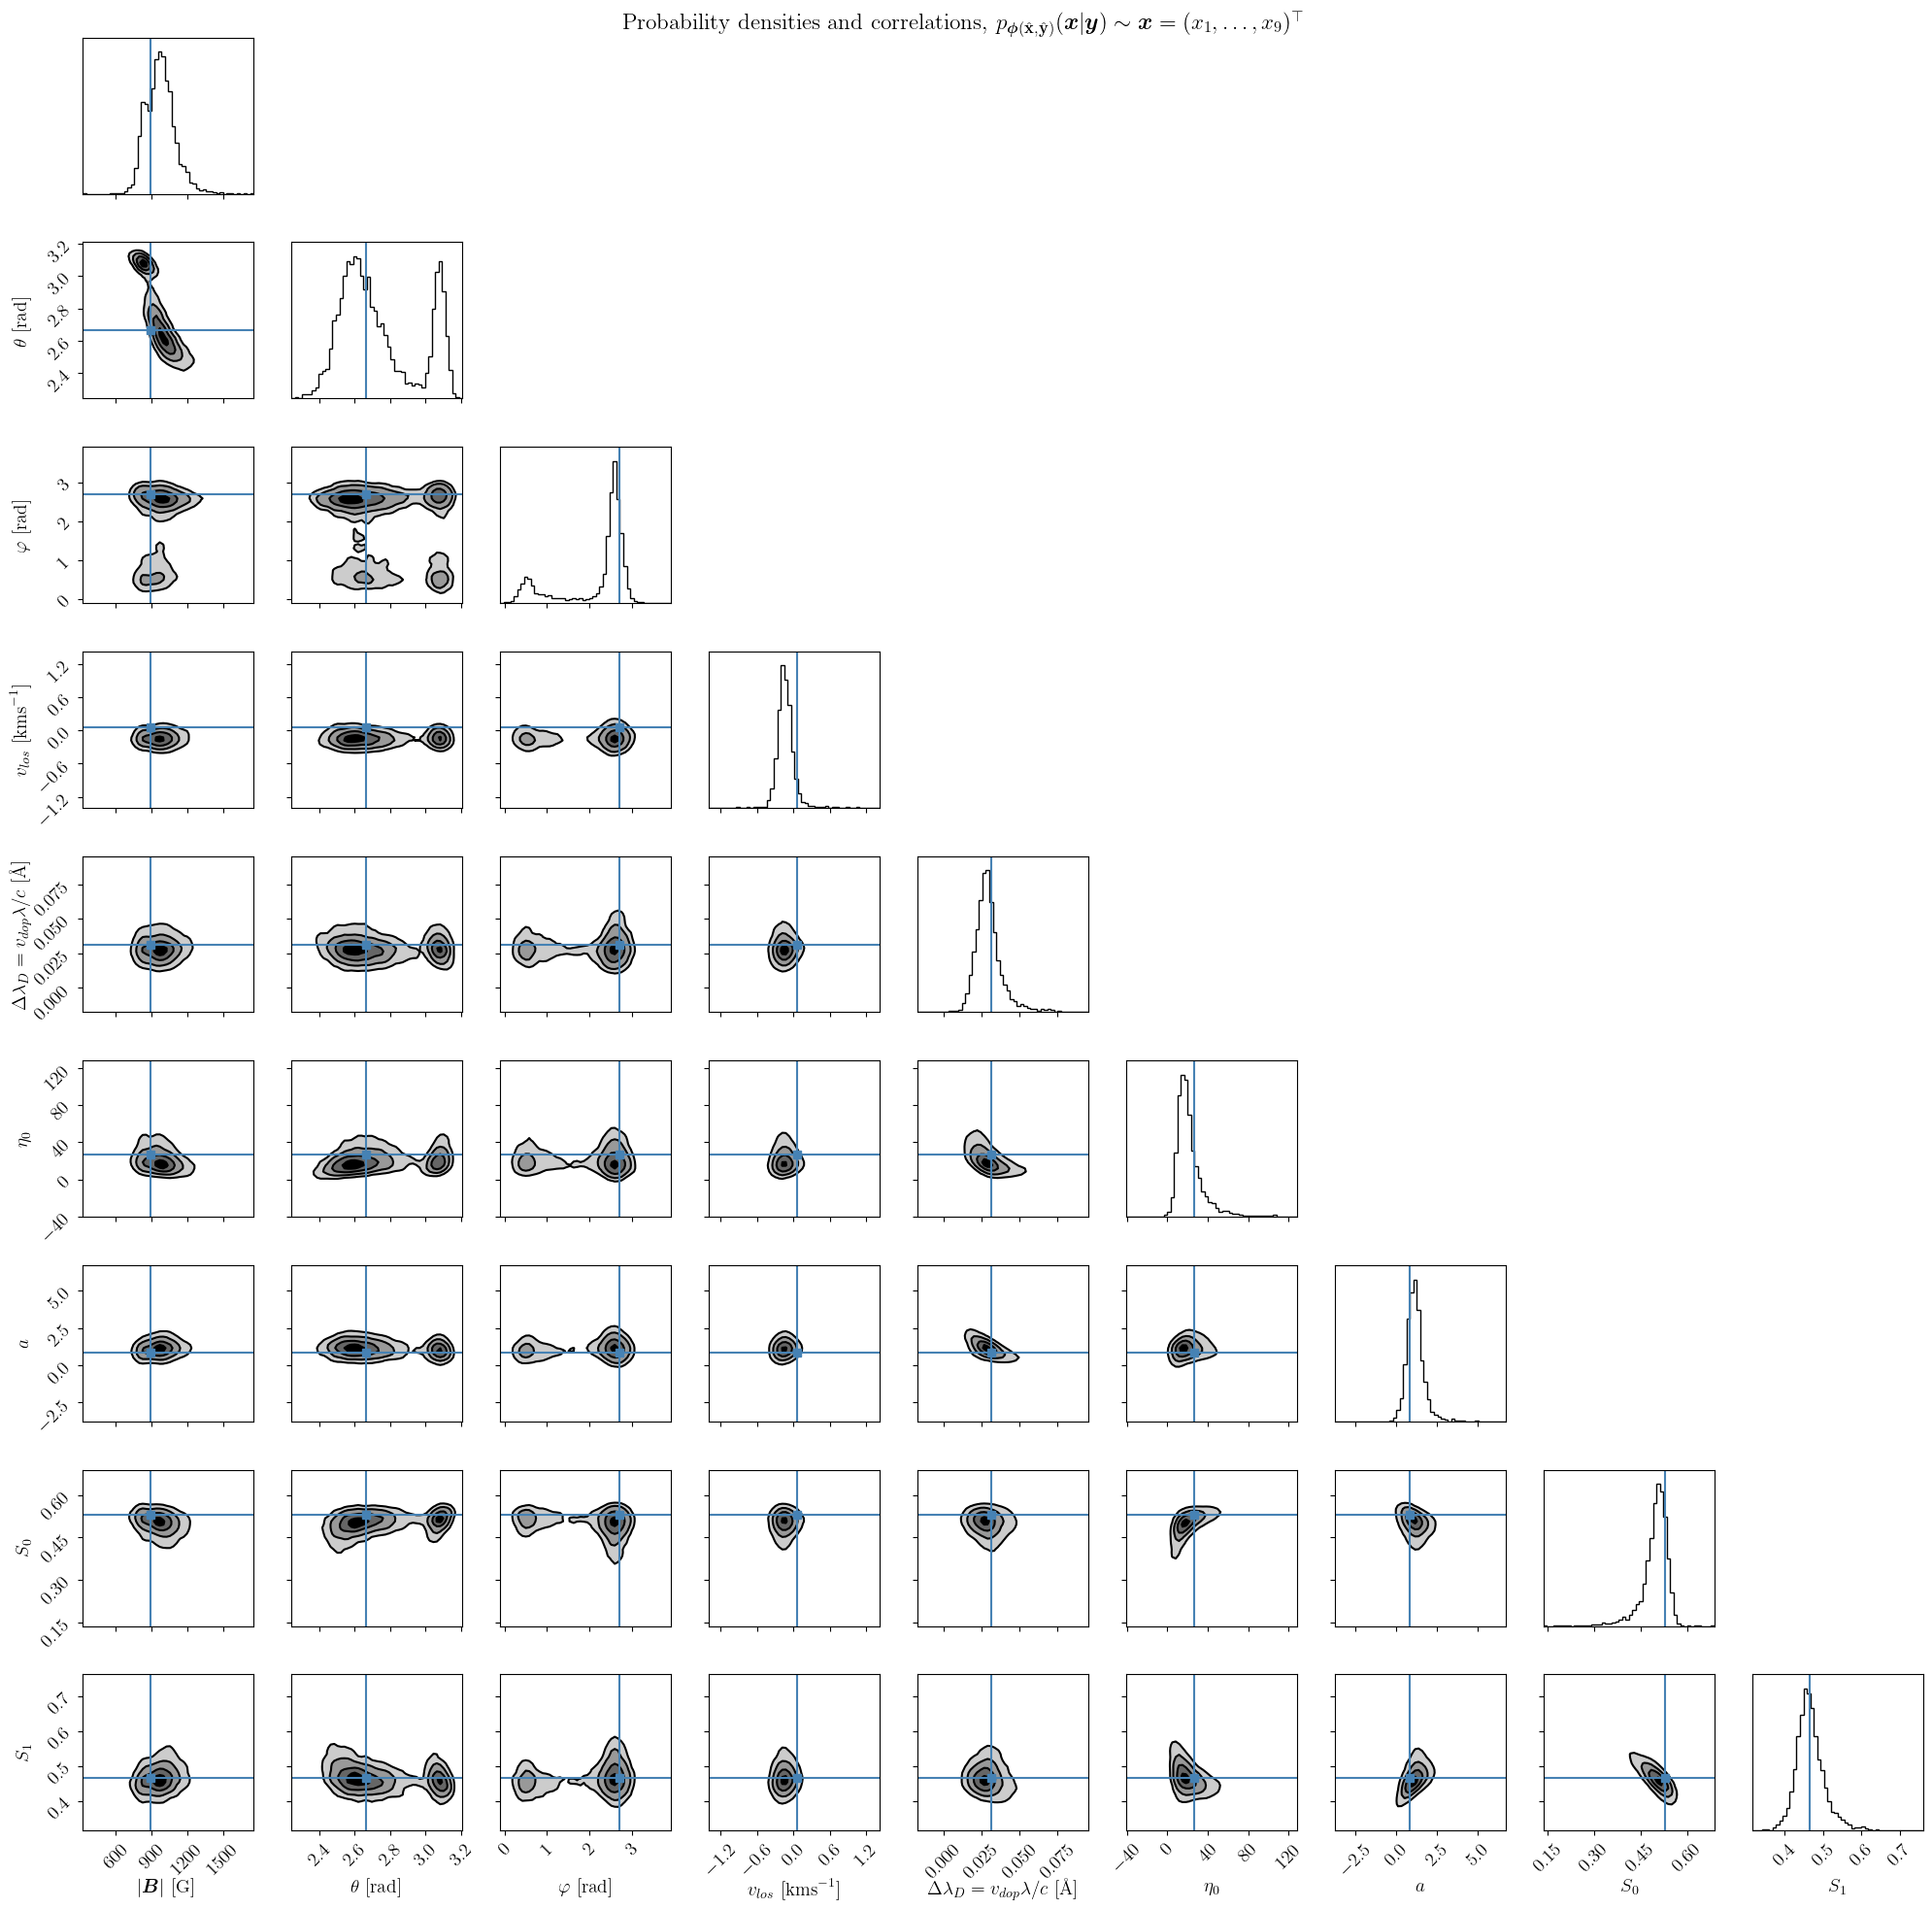

In [30]:
# Produce corner plot
figure = corner.corner(rec_x, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-5-corner-2train-nflows-piecewisequadratic.pdf')

In [31]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

batch_size  :  1024
input_size  :  9
context_size  :  52
hidden_size  :  16
num_layers  :  5
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  10
which_dataindex  :  175000
exp_samples  :  5000


In [32]:
# Invert the first map using the trained normalizing flow
parameters_map19_2train, err_parameters_map19_2train = invert_nflow(spectra_map19, parameters_map19.shape[1], flow, y_scaler_map19, x_scaler_map19)
np.save('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/parameters_map19_2train.npy', parameters_map19_2train)
np.save('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/err_parameters_map19_2train.npy', err_parameters_map19_2train)

100%|█████████████████████████████████████████████████████████████████████████| 330000/330000 [2:33:34<00:00, 35.81it/s]


# Train on first, second and third map, test on last map
## Define training and testing datasets, dataloaders and train the flow

In [33]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [34]:
# Instantiate params dictionary
settings = dictionary()

In [35]:
# Reshape training data
spectra_map0 = map_inv_dict[0].reshape(map_inv_dict[0].shape[0]*map_inv_dict[0].shape[1], map_inv_dict[0].shape[2]*map_inv_dict[0].shape[3])
spectra_map1 = map_inv_dict[1].reshape(map_inv_dict[1].shape[0]*map_inv_dict[1].shape[1], map_inv_dict[1].shape[2]*map_inv_dict[1].shape[3])
spectra_map2 = map_inv_dict[2].reshape(map_inv_dict[2].shape[0]*map_inv_dict[2].shape[1], map_inv_dict[2].shape[2]*map_inv_dict[2].shape[3])
parameters_map0 = inverted_map_dict[0].reshape(inverted_map_dict[0].shape[0]*inverted_map_dict[0].shape[1], inverted_map_dict[0].shape[2])
parameters_map1 = inverted_map_dict[1].reshape(inverted_map_dict[1].shape[0]*inverted_map_dict[1].shape[1], inverted_map_dict[1].shape[2])
parameters_map2 = inverted_map_dict[2].reshape(inverted_map_dict[2].shape[0]*inverted_map_dict[2].shape[1], inverted_map_dict[2].shape[2])

# Create datasets of training data
spectra = np.vstack((spectra_map0, spectra_map1, spectra_map2))
parameters = np.vstack((parameters_map0, parameters_map1, parameters_map2))

# Create datasets of testing data
spectra_map19 = map_inv_dict[19].reshape(map_inv_dict[19].shape[0]*map_inv_dict[19].shape[1], map_inv_dict[19].shape[2]*map_inv_dict[19].shape[3])
parameters_map19 = inverted_map_dict[19].reshape(inverted_map_dict[19].shape[0]*inverted_map_dict[19].shape[1], inverted_map_dict[19].shape[2])

In [36]:
# Print shape of data
print(f'Shape of true spectra data is: {spectra.shape}')
print(f'Shape of true parameters data is: {parameters.shape}')

Shape of true spectra data is: (990000, 52)
Shape of true parameters data is: (990000, 9)


In [37]:
# Test for NaN values in data
has_nan = np.isnan(spectra).any()
if has_nan==False:
    has_nan = np.isnan(parameters).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [38]:
# Define input x and context y
x = parameters # parameters
y = spectra # spectra

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define scalers for testing map
x_scaler_map19 = StandardScaler().fit(parameters_map19)
y_scaler_map19 = StandardScaler().fit(spectra_map19)
x_std_map19 = x_scaler_test.transform(parameters_map19)
y_std_map19 = y_scaler_test.transform(spectra_map19)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (891000, 9)
Context y_std_train shape: (891000, 52)
Output z_train shape: (891000, 9)
Input x_std_test shape: (99000, 9)
Context y_std_test shape: (99000, 52)
Output z_test shape: (99000, 9)


In [39]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [40]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([891000, 9])
Size of y_std_train: torch.Size([891000, 52])
Size of z_train: torch.Size([891000, 9])
Size of x_std_test: torch.Size([99000, 9])
Size of y_std_test: torch.Size([99000, 52])
Size of z_test: torch.Size([99000, 9])


In [41]:
# Define dataloaders for training and testing
settings.batch_size = 3*512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [42]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 16
settings.num_layers = 5

In [43]:
# Define functions for flow definitions
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

In [44]:
# Instantiate the normalizing flow
base_dist = StandardNormal(shape=[settings.input_size])
flowtransforms = []
for _ in range(settings.num_layers):
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
    flowtransforms.append(PiecewiseRationalQuadraticCouplingTransform(_, settings.input_size,
                                                                      settings.hidden_size, context_size=settings.context_size))
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
flowtransforms = CompositeTransform(flowtransforms)

flow = Flow(flowtransforms, base_dist)

In [45]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 10

# Define optimizer and scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

In [46]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        flow.train()
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        flow.eval()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/10 train loss: -0.0001
Epoch 1/10 test loss: -0.0027
Epoch 2/10 train loss: -0.0035
Epoch 2/10 test loss: -0.0039
Epoch 3/10 train loss: -0.0041
Epoch 3/10 test loss: -0.0042
Epoch 4/10 train loss: -0.0044
Epoch 4/10 test loss: -0.0045
Epoch 5/10 train loss: -0.0046
Epoch 5/10 test loss: -0.0046
Epoch 6/10 train loss: -0.0047
Epoch 6/10 test loss: -0.0047
Epoch 7/10 train loss: -0.0047
Epoch 7/10 test loss: -0.0047
Epoch 8/10 train loss: -0.0048
Epoch 8/10 test loss: -0.0047
Epoch 9/10 train loss: -0.0048
Epoch 9/10 test loss: -0.0047
Epoch 10/10 train loss: -0.0048
Epoch 10/10 test loss: -0.0047


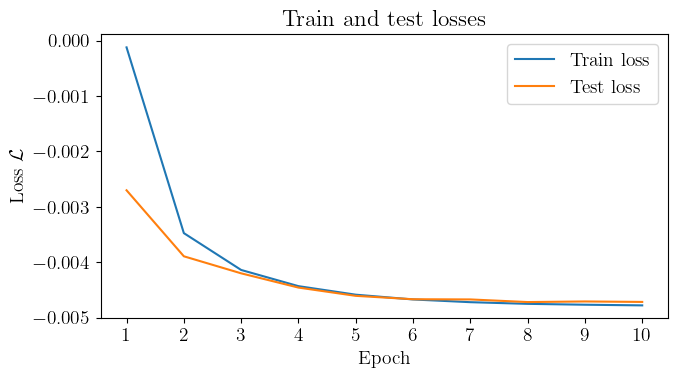

In [47]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-5-loss-3train-nflows-piecewisequadratic.pdf')

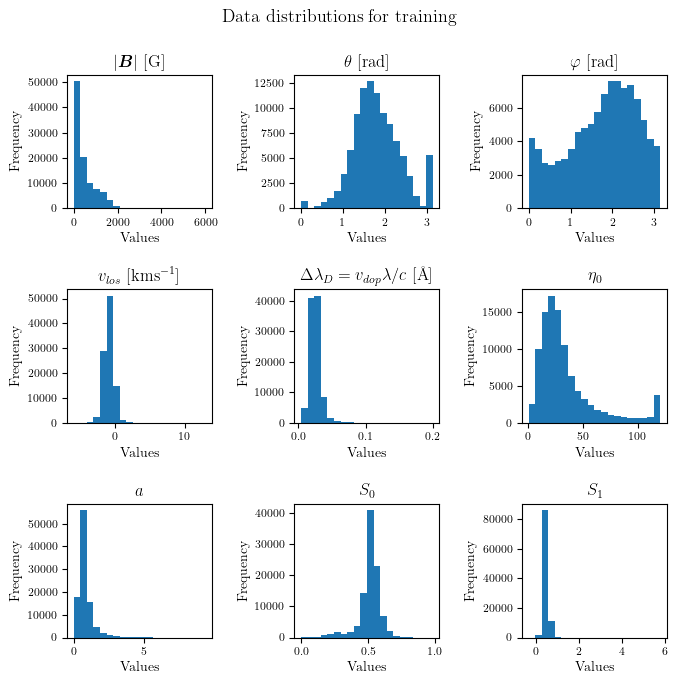

In [48]:
# Plot histogram of training data
plot_histograms(x_test, l_units, 'Data distributions for training', savename='nf-milne-eddington-example-5-datadistributiontraining-3train-nflows-piecewisequadratic.pdf')

## Invert last map using the trained normalizing flow

In [49]:
# Take a sample from the testing map
settings.which_dataindex = 175000
settings.exp_samples = 5000
expval = parameters_map19[settings.which_dataindex,:]
expobs = spectra_map19[settings.which_dataindex,:]
z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_scaler_map19.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x = x_scaler_map19.inverse_transform(rec_x_std[0])

In [50]:
# Plot actual values of features for tested spectrum
for i in range(len(labels)):
    print(f'{labels[i]}: {expval[i]}')

$|\bm{B}|$: 892.6149291992188
$\theta$: 2.664478063583374
$\varphi$: 2.7033779621124268
$v_{los}$: 0.0541003942489624
$\Delta \lambda_D = v_{dop}\lambda/c$: 0.03092404268682003
$\eta_0$: 26.957412719726562
$a$: 0.837792694568634
$S_0$: 0.530448853969574
$S_1$: 0.4645920991897583


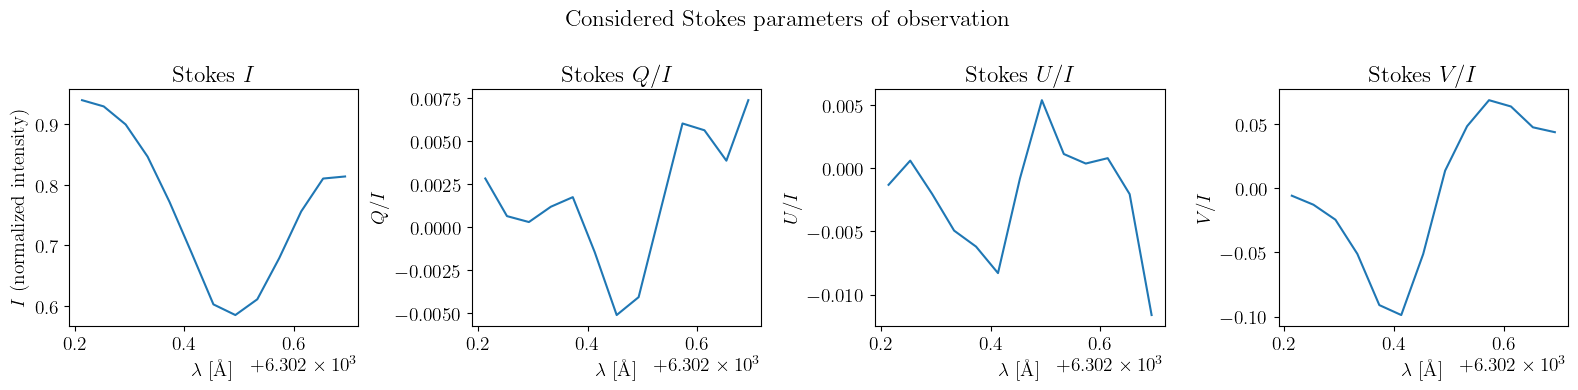

In [51]:
# Plot stokes profiles
plot_stokes_simple(spectra_map19, regions_dict[19][0][0], settings.which_dataindex, stokes_labels, title='Considered Stokes parameters of observation')

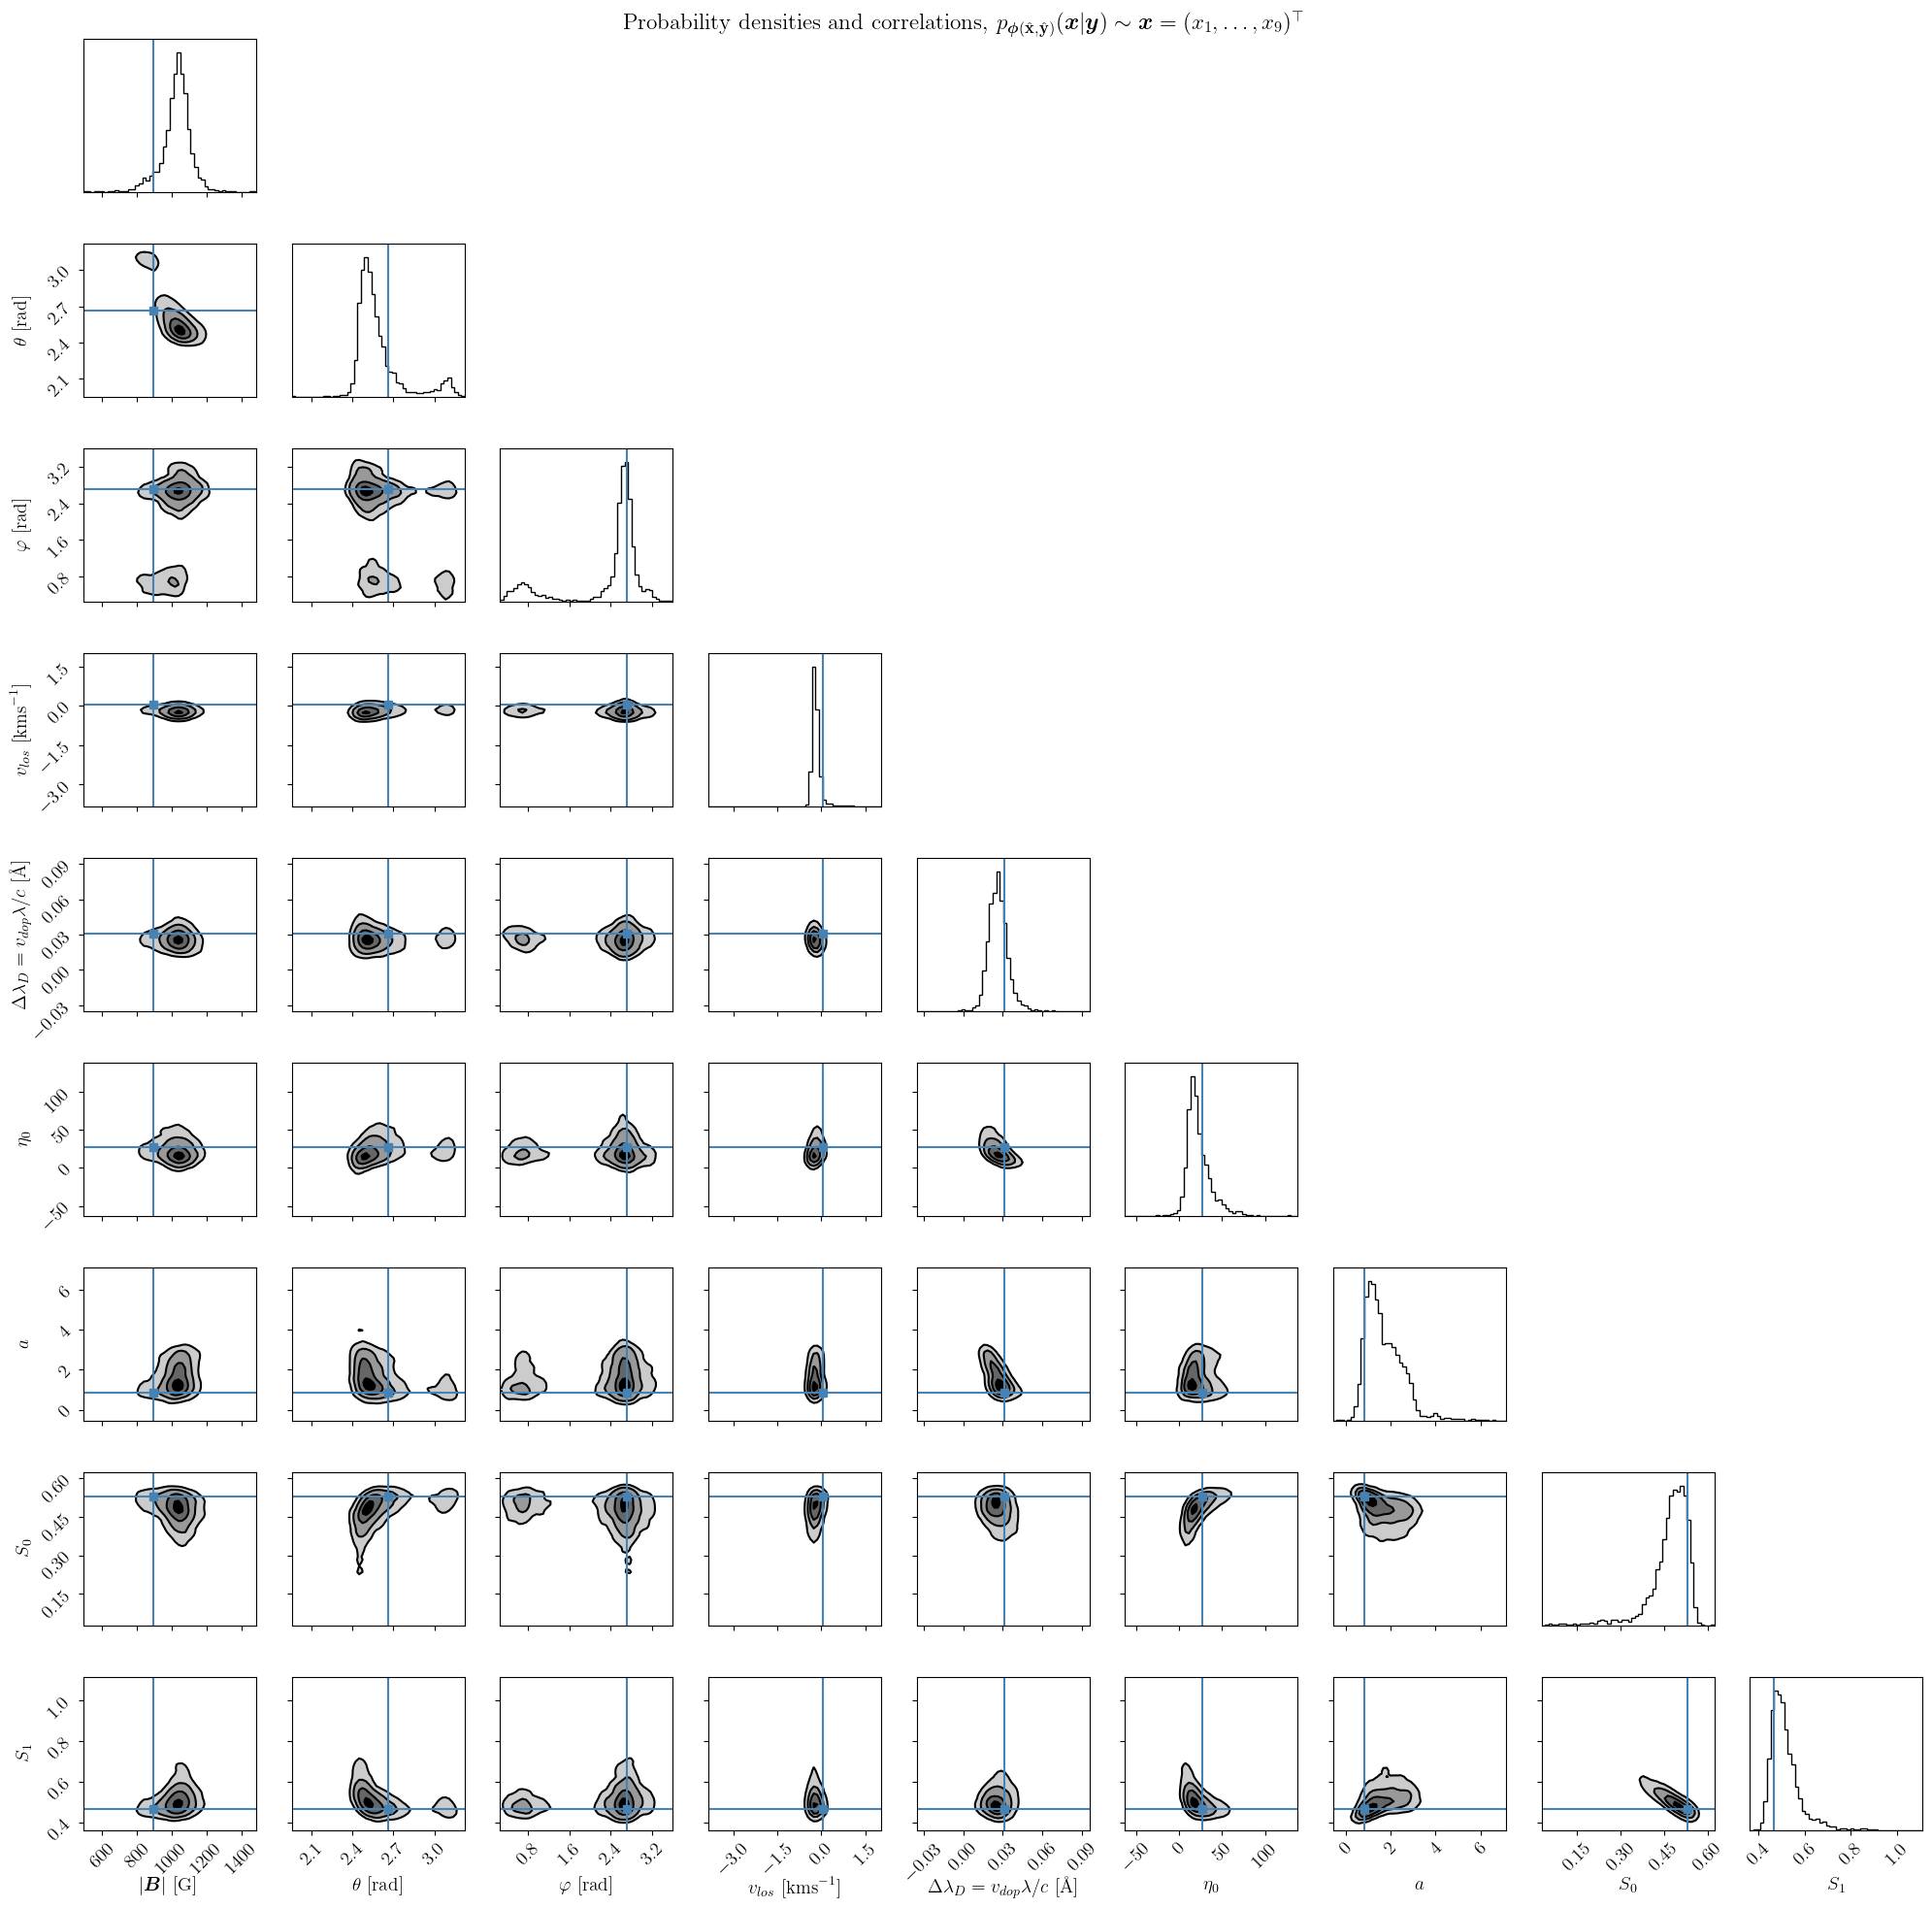

In [52]:
# Produce corner plot
figure = corner.corner(rec_x, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-5-corner-3train-nflows-piecewisequadratic.pdf')

In [53]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

batch_size  :  1536
input_size  :  9
context_size  :  52
hidden_size  :  16
num_layers  :  5
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  10
which_dataindex  :  175000
exp_samples  :  5000


In [54]:
# Invert the first map using the trained normalizing flow
parameters_map19_3train, err_parameters_map19_3train = invert_nflow(spectra_map19, parameters_map19.shape[1], flow, y_scaler_map19, x_scaler_map19)
np.save('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/parameters_map19_3train.npy', parameters_map19_3train)
np.save('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/err_parameters_map19_3train.npy', err_parameters_map19_3train)

100%|█████████████████████████████████████████████████████████████████████████| 330000/330000 [2:39:24<00:00, 34.50it/s]


# Do tests and plots
(Executable without executing the prior cells, except for the package imports).

In [1]:
# Import all important packages
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
import numpy as np
import seaborn as sns
from astropy.io import fits
from scipy.interpolate import CubicSpline
from matplotlib.patches import Rectangle

from utils import *

In [2]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

In [3]:
# Read maps
map_inv0, hdulist0, regions0 = read_map_pf('/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_0.fits')
map_inv1, hdulist1, regions1 = read_map_pf('/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_1.fits')
map_inv2, hdulist2, regions2 = read_map_pf('/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_2.fits')
map_inv19, hdulist19, regions19 = read_map_pf('/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_19.fits')

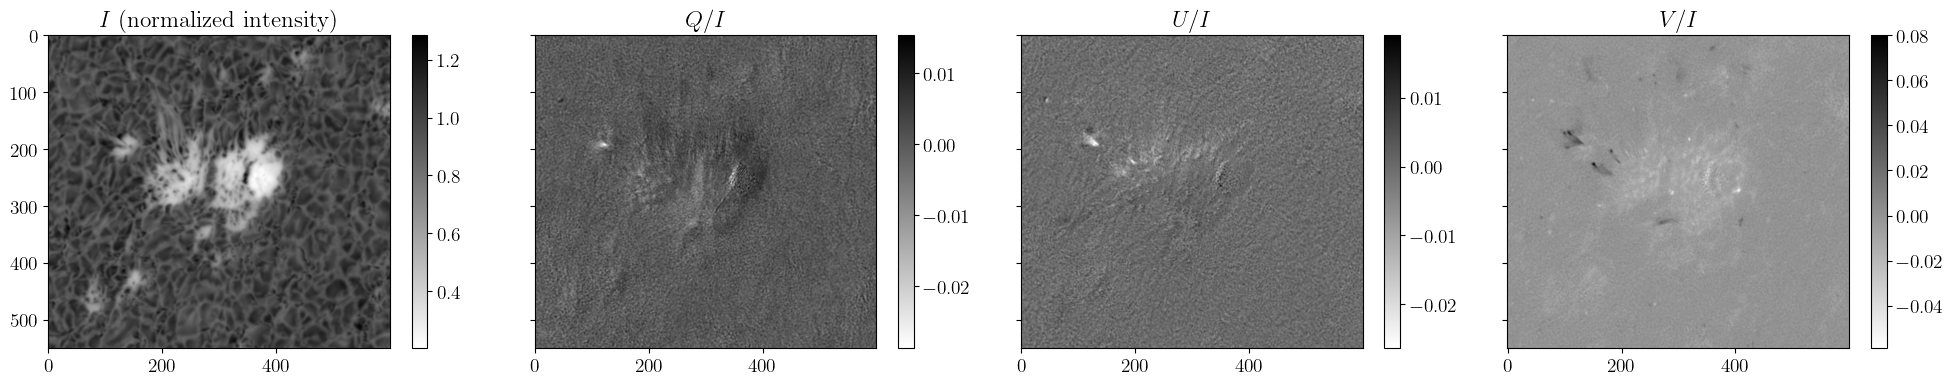

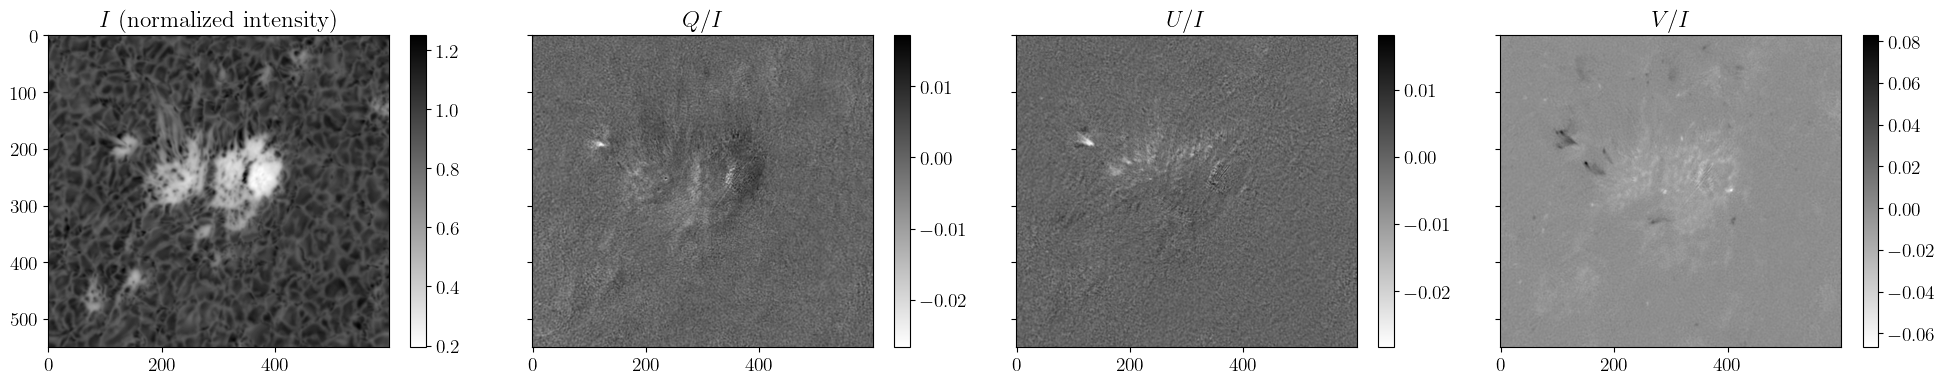

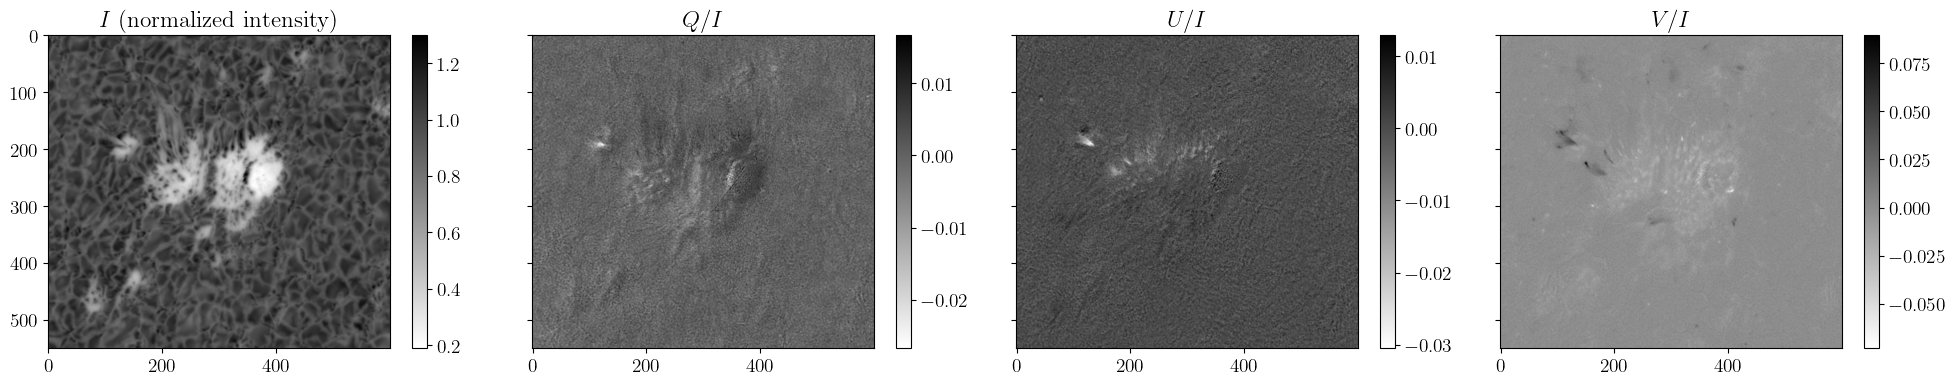

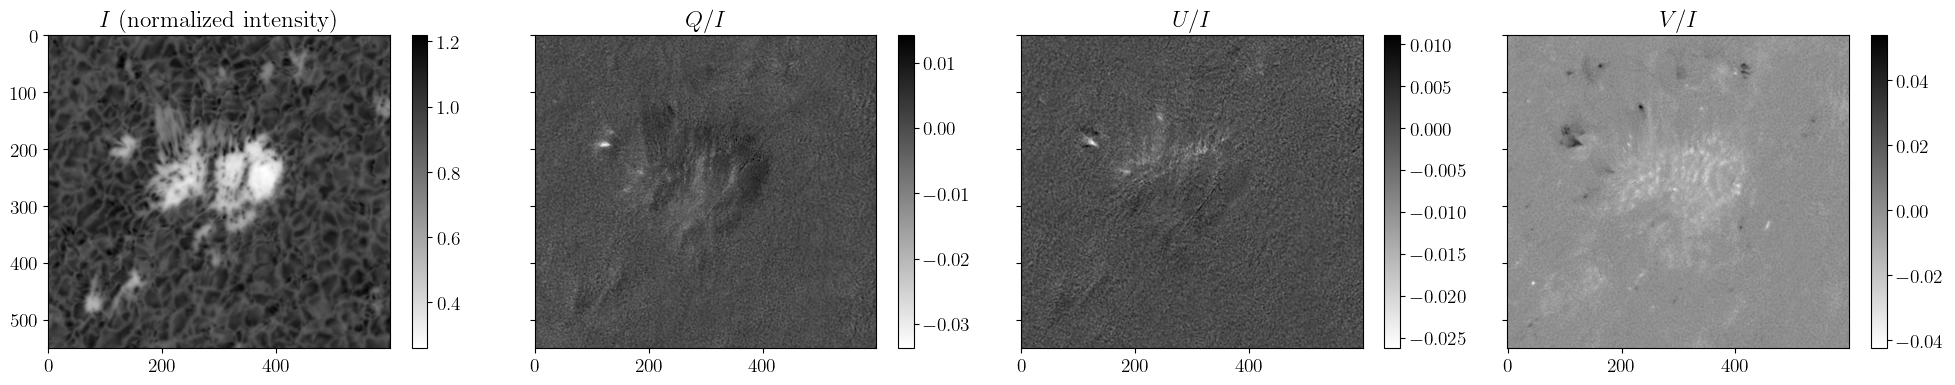

In [4]:
# Plot map examples
plot_four_images(map_inv0, 0, stokes_labels, 'nf-milne-eddington-example-5-map0-nflows-piecewisequadratic.pdf')
plot_four_images(map_inv1, 0, stokes_labels, 'nf-milne-eddington-example-5-map1-nflows-piecewisequadratic.pdf')
plot_four_images(map_inv2, 0, stokes_labels, 'nf-milne-eddington-example-5-map2-nflows-piecewisequadratic.pdf')
plot_four_images(map_inv19, 0, stokes_labels, 'nf-milne-eddington-example-5-map19-nflows-piecewisequadratic.pdf')

In [5]:
# NF inversion
parameters_map19_1train = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/parameters_map19_1train.npy')
parameters_map19_2train = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/parameters_map19_2train.npy')
parameters_map19_3train = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/parameters_map19_3train.npy')

# NF inversion errors
err_parameters_map19_1train = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/err_parameters_map19_1train.npy')
err_parameters_map19_2train = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/err_parameters_map19_2train.npy')
err_parameters_map19_3train = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/err_parameters_map19_3train.npy')

# ME inversion
inverted_map19 = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/inverted_map19.npy')

# ME inversion errors
errors_map19 = np.load('/home/dz/Python files/milne-eddington/nf-milne-eddington-example-5-nflows-piecewisequadratic/errors_map19.npy')

In [6]:
# Reshape parameter and error arrays
parameters_map19_1train_r = parameters_map19_1train.reshape(550,600,9)
parameters_map19_2train_r = parameters_map19_2train.reshape(550,600,9)
parameters_map19_3train_r = parameters_map19_3train.reshape(550,600,9)

err_parameters_map19_1train_r = err_parameters_map19_1train.reshape(550,600,9)
err_parameters_map19_2train_r = err_parameters_map19_2train.reshape(550,600,9)
err_parameters_map19_3train_r = err_parameters_map19_3train.reshape(550,600,9)

inverted_map19_r = inverted_map19.reshape(550,600,9)

errors_map19_r = errors_map19.reshape(550,600,9)

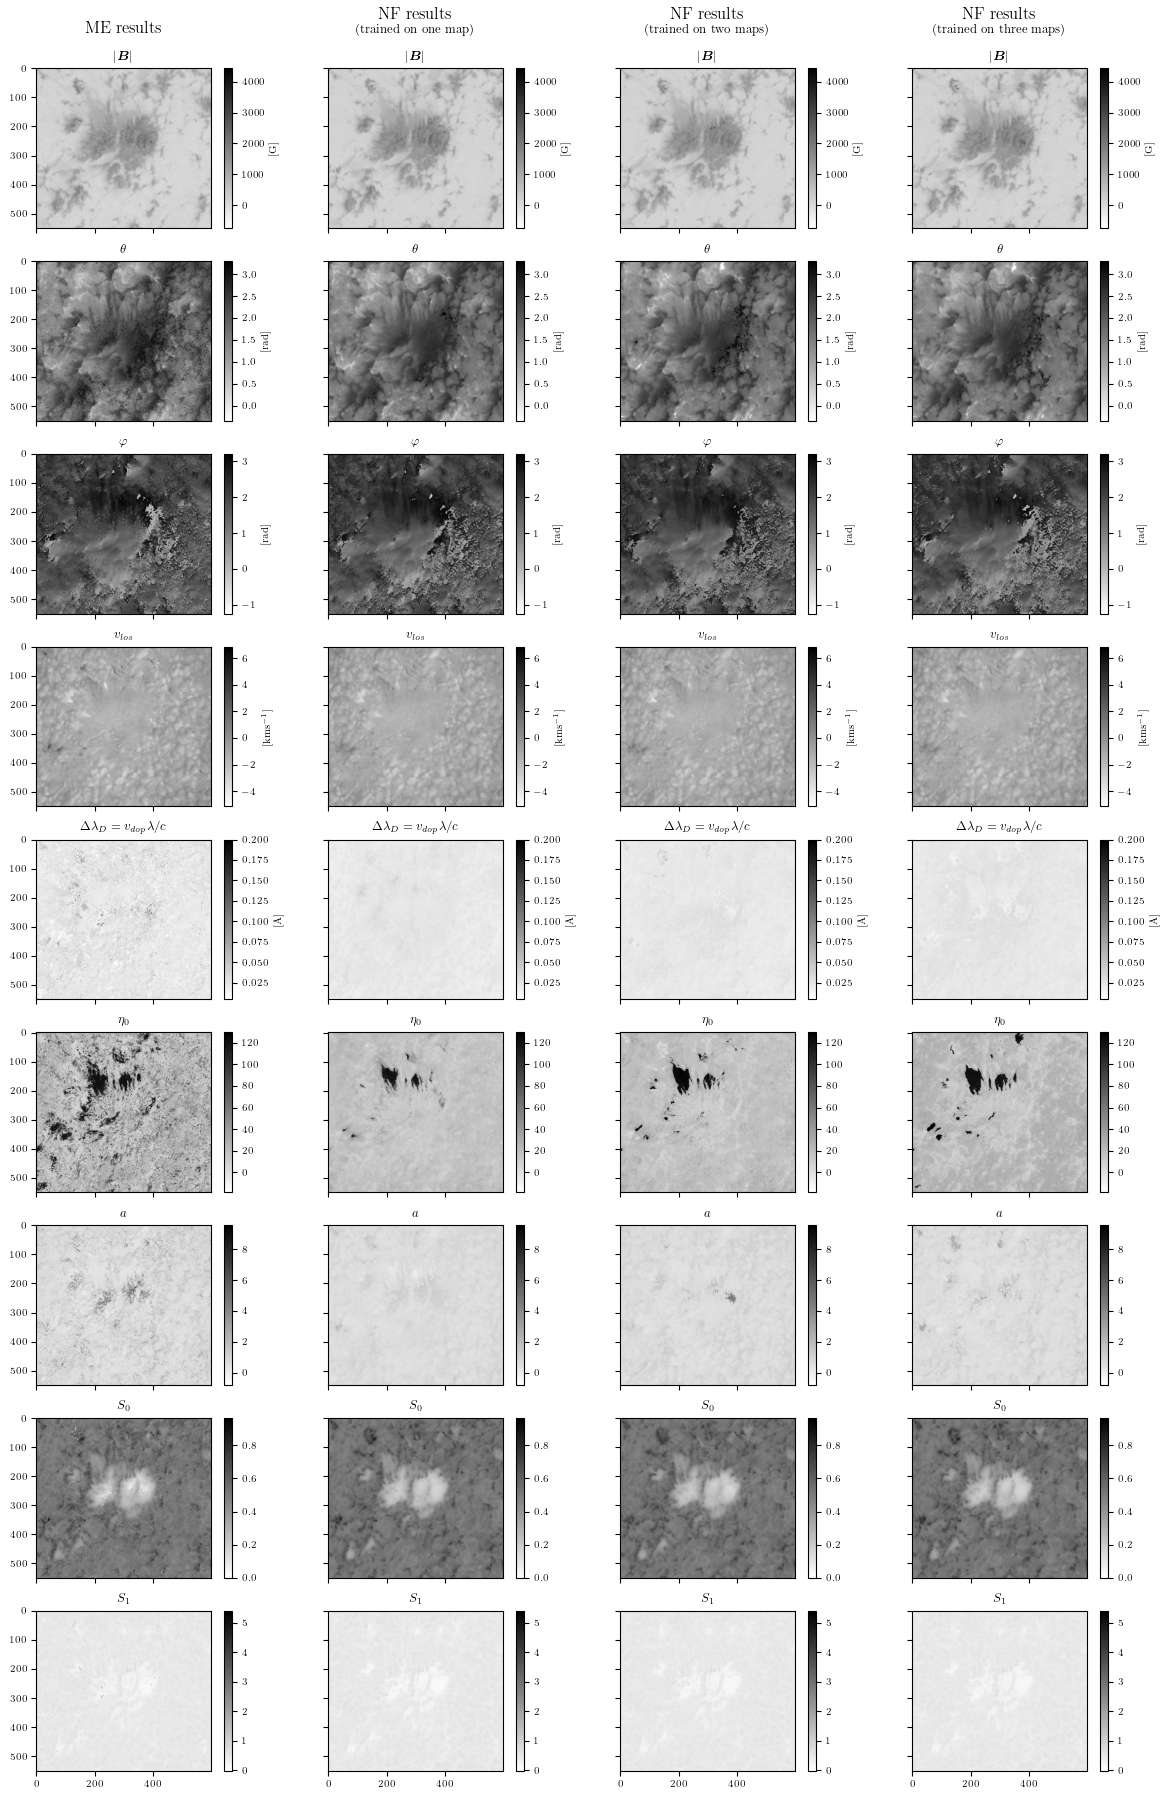

In [15]:
# Plot comparison between Milne-Eddington-inverted data and normalizing-flow-inverted data
plot_inversion_results_seq(inverted_map19_r, parameters_map19_1train_r, parameters_map19_2train_r, parameters_map19_3train_r, 'ME results', 'NF results\n(trained on one map)', 'NF results\n(trained on two maps)', 'NF results\n(trained on three maps)', labels, units, savename='nf-milne-eddington-example-5-nflows-piecewisequadratic-comp-ME-NF-map19.pdf')

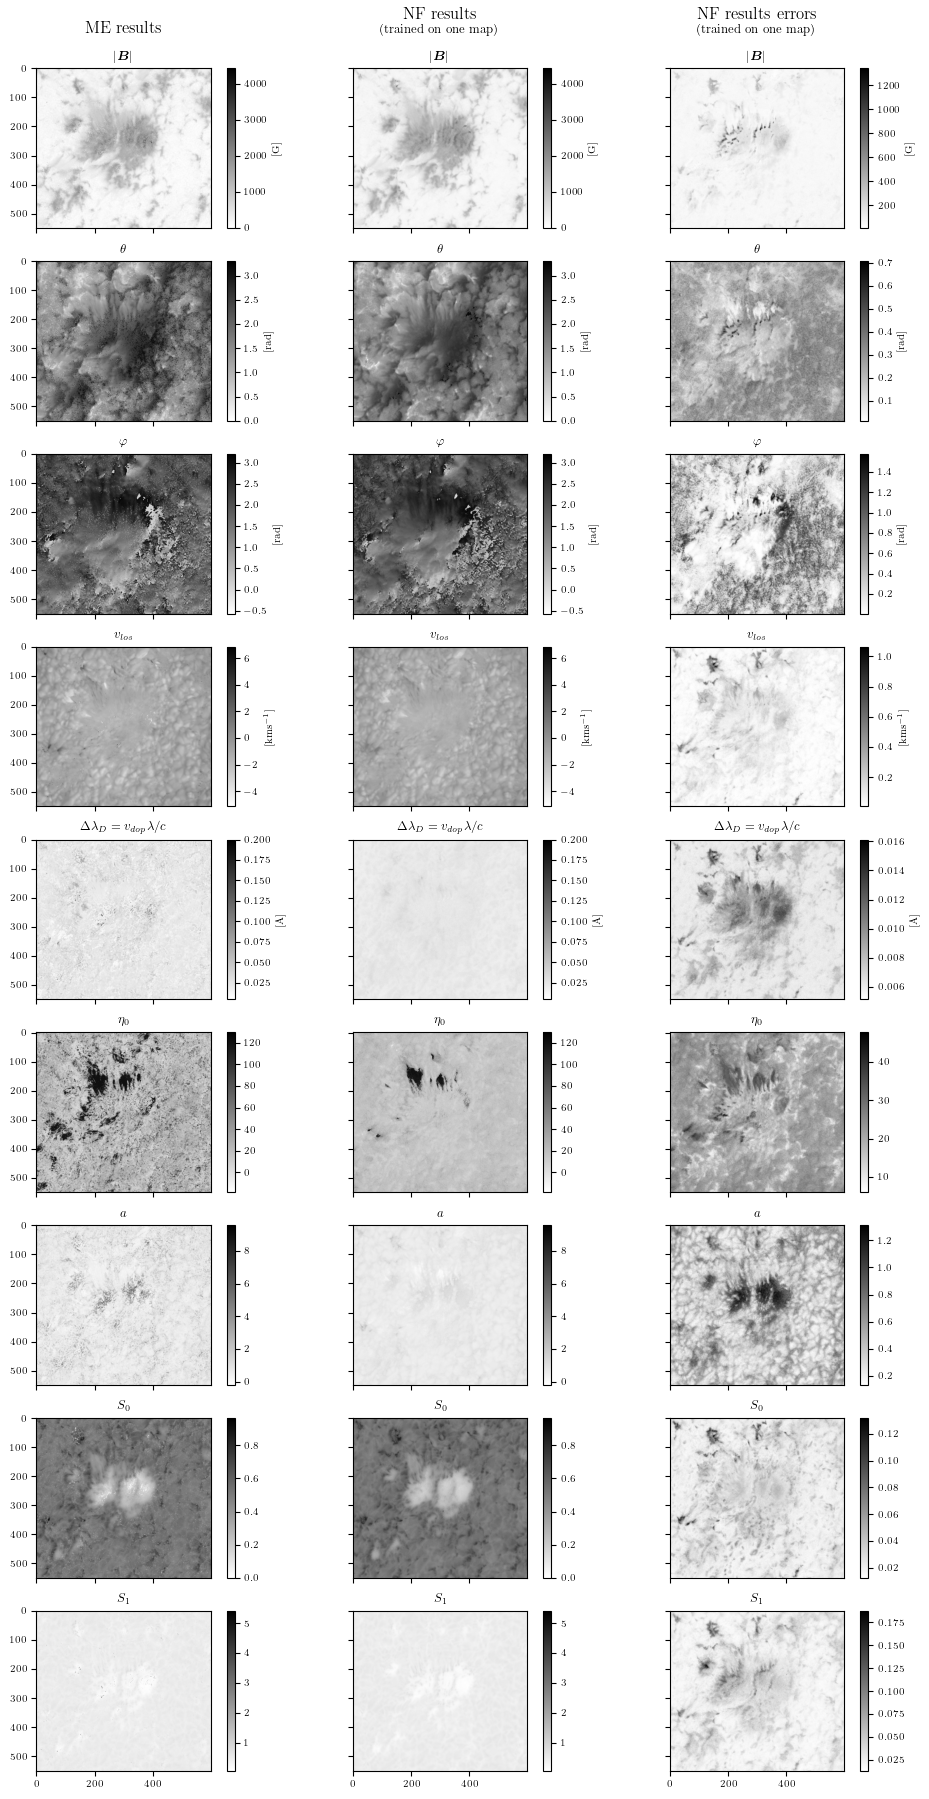

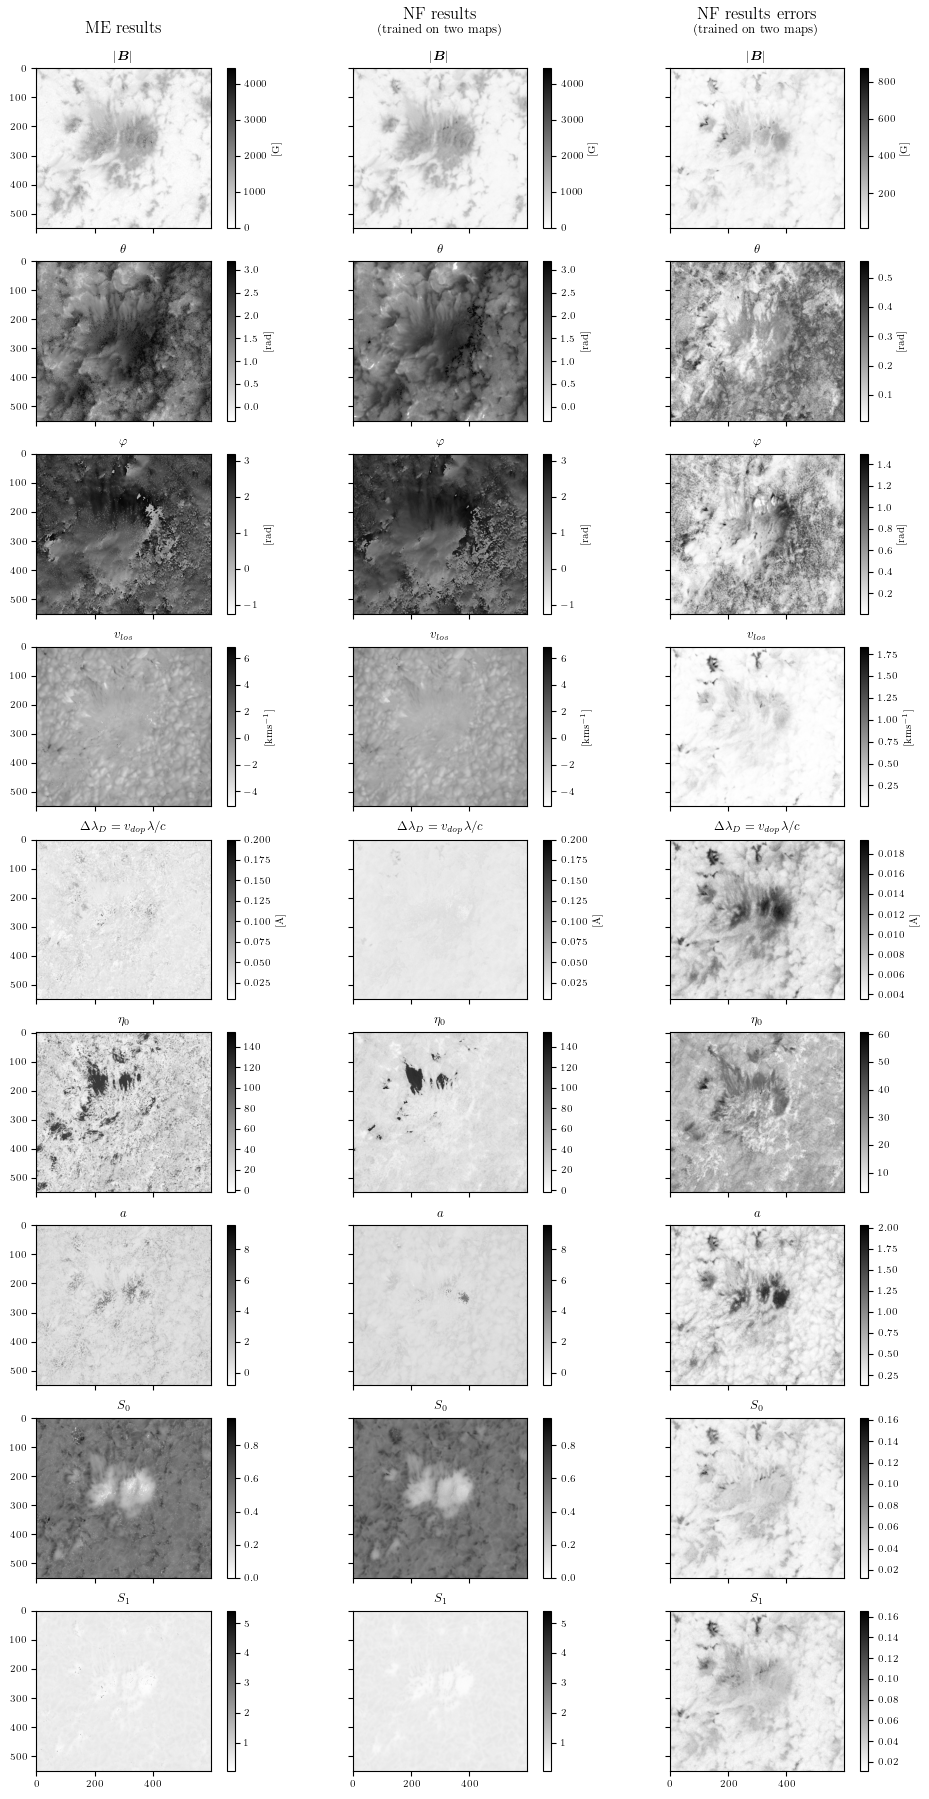

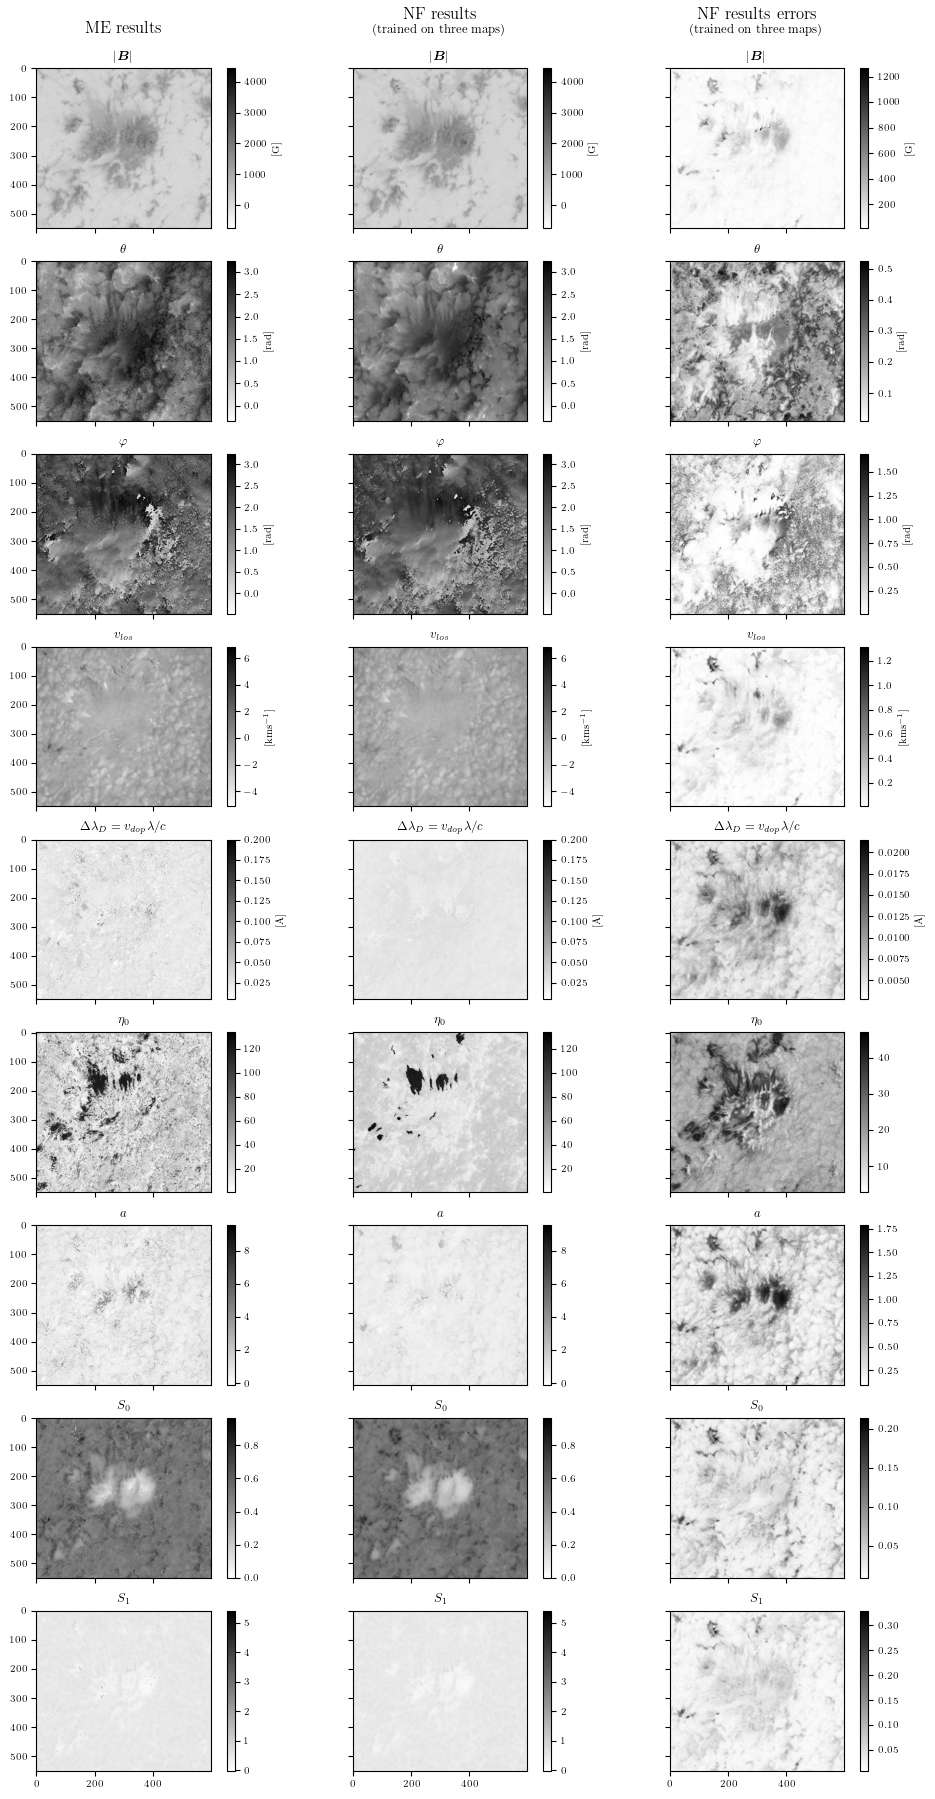

In [16]:
# Plot comparison between Milne-Eddington-inverted data and normalizing-flow-inverted data
plot_inversion_results(inverted_map19_r, parameters_map19_1train_r, err_parameters_map19_1train_r, 'ME results', 'NF results\n(trained on one map)', 'NF results errors\n(trained on one map)', labels, units, savename='nf-milne-eddington-example-5-nflows-piecewisequadratic-comp-ME-NF-map19_tr_on_1.pdf', samescale=True)
plot_inversion_results(inverted_map19_r, parameters_map19_2train_r, err_parameters_map19_2train_r, 'ME results', 'NF results\n(trained on two maps)', 'NF results errors\n(trained on two maps)', labels, units, savename='nf-milne-eddington-example-5-nflows-piecewisequadratic-comp-ME-NF-map19_tr_on_2.pdf', samescale=True)
plot_inversion_results(inverted_map19_r, parameters_map19_3train_r, err_parameters_map19_3train_r, 'ME results', 'NF results\n(trained on three maps)', 'NF results errors\n(trained on three maps)', labels, units, savename='nf-milne-eddington-example-5-nflows-piecewisequadratic-comp-ME-NF-map19_tr_on_3.pdf', samescale=True)